Ноутбук с лекции https://colab.research.google.com/drive/1SHTooPUjXNfR6PyFh2fWrCgx6ebyqAW3

Что сделать?  
Используя признаки, сгенерированные в предыдущих ДЗ:
Обучить логистическую регрессию:

Подготовить признаки
Выбрать значимые признаки
Подобрать на кроссвалидации параметры

Обучить дерево решений:

Выбрать признаки и подобрать параметры на кроссвалидации
Сравните результаты, полученные с помощью логистической регрессии и дерева.

Общие требования (упорядочены в порядки убывания важности):
Скрипты загружены в GitLab, сделан МР с изменениями, предоставлена ссылка на МР
Код является воспроизводимым
Приемлемое время выполнения скрипта.
Скрипт содержит функцию main(), при вызове которая:
- Выполняет загрузку данных, выбор и обучение оптимальной модели. 
- Выводит на печать итоговое качество моделей на тестовом датасете
- Сохраняет полученные модели в pickle файл
- Имеется возможность задавать пути к входному и результирующим файлам.
Структура и качество кода:
Выделение отдельных логических частей в виде функций
Вынесение общей логики в отдельные функции с целью переиспользования
Документирование кода
Осмысленные имена переменных

In [301]:
import json
import os
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu, chi2_contingency, ttest_ind 
from scipy.stats import anderson, anderson_ksamp
from scipy.stats import chi2, t, sem
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import random
import warnings
warnings.filterwarnings('ignore')
from dataclasses import asdict
from datetime import datetime, date
import io

all_data = pd.read_csv('/kaggle/input/shiftlogs/application_train.csv')

In [302]:
house_columns = ['NAME_HOUSING_TYPE', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG',
                 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
                 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
                 'YEARS_BUILD_MODE' ,'COMMONAREA_MODE' , 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE',
                 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE' ,'APARTMENTS_MEDI',
                 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI',
                 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI',
                 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']

In [303]:
application_train_test = pd.DataFrame()

application_train_test['SK_ID_CURR'] = all_data['SK_ID_CURR']

application_train_test['TARGET'] = all_data['TARGET']

application_train_test['Кол-во документов'] = all_data.loc[:, 'FLAG_DOCUMENT_2': 'FLAG_DOCUMENT_21'].sum(axis=1)

application_train_test['Информация о доме'] = np.where(all_data.loc[:, house_columns].isnull().sum(axis=1) < 30, 1, 0)

application_train_test['Кол-во полных лет'] = abs(all_data['DAYS_BIRTH']/365).apply(np.int64)

application_train_test['Год смены документа'] = application_train_test['Кол-во полных лет'] - abs(all_data['DAYS_REGISTRATION']/365).apply(np.int64)

# application_train_test['Разница во времени между сменой документа и возрастом на момент смены документы'] = вообще не понял вопроса =)

application_train_test['Признак задержки смены документа'] = np.where(application_train_test['Год смены документа'] != 14|20|45, 1, 0)

application_train_test['Доля денег которые клиент отдает на займ за год'] = all_data['AMT_ANNUITY']/all_data['AMT_INCOME_TOTAL']

application_train_test['Среднее кол-во детей в семье на одного взрослого'] = all_data['CNT_CHILDREN'] / (all_data['CNT_FAM_MEMBERS'] - all_data['CNT_CHILDREN']) 

application_train_test['Средний доход на ребенка'] = all_data['AMT_INCOME_TOTAL'] / all_data['CNT_CHILDREN']

application_train_test['Средний доход на взрослого'] = all_data['AMT_INCOME_TOTAL'] / (all_data['CNT_FAM_MEMBERS'] - all_data['CNT_CHILDREN'])

application_train_test['Процентная ставка'] = ((all_data['AMT_CREDIT'] - all_data['AMT_GOODS_PRICE']) / ((all_data['AMT_CREDIT'] / all_data['AMT_ANNUITY']) / 12)) / all_data['AMT_GOODS_PRICE']

application_train_test[['скор внеешних источников1', 'скор внеешних источников2', 'скор внеешних источников3']] = all_data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]

In [304]:
# экономим время, обрезаем датасет
application_train_test = application_train_test.dropna() 
application_train_test = application_train_test.sample(1000)
application_train_test

,SK_ID_CURR,TARGET,Кол-во документов,Информация о доме,Кол-во полных лет,Год смены документа,Признак задержки смены документа,Доля денег которые клиент отдает на займ за год,Среднее кол-во детей в семье на одного взрослого,Средний доход на ребенка,Средний доход на взрослого,Процентная ставка,скор внеешних источников1,скор внеешних источников2,скор внеешних источников3
143024,265831,1,1,1,28,16,1,0.304067,0.0,inf,135000.0,0.213427,0.125690,0.274294,0.713631
16885,119690,0,1,1,24,15,1,0.189875,0.0,inf,180000.0,0.000000,0.084293,0.355005,0.420611
220729,355706,0,0,0,58,35,1,0.137500,0.0,inf,90000.0,0.000000,0.629028,0.592121,0.522697
109920,227479,0,0,1,42,38,1,0.100000,0.0,inf,45000.0,0.000000,0.245877,0.736736,0.202087
45705,152946,1,1,1,38,23,1,0.171507,0.5,337500.0,168750.0,0.091239,0.523690,0.602273,0.259468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263481,405068,0,1,0,23,15,1,0.079829,0.0,inf,78750.0,0.000000,0.077341,0.495678,0.678568
108369,225708,0,1,0,27,26,1,0.351000,0.5,135000.0,67500.0,0.000000,0.342547,0.468527,0.656158
234266,371364,0,1,0,41,41,1,0.171480,1.0,112500.0,112500.0,0.097702,0.423074,0.190081,0.631355
244006,382448,0,1,0,36,26,1,0.114111,0.0,inf,202500.0,0.000000,0.250490,0.499964,0.243186


In [305]:
feature_1 = 'Год смены документа'
min_feature_1 = application_train_test[feature_1].min()
max_feature_1 = application_train_test[feature_1].max()
feature_2 = 'Кол-во полных лет'
min_feature_2 = application_train_test[feature_2].min()
max_feature_2 = application_train_test[feature_2].max()

<AxesSubplot:xlabel='Год смены документа'>

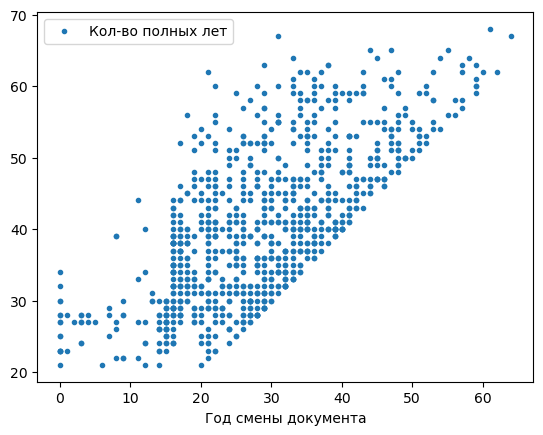

In [306]:
application_train_test[application_train_test['TARGET']==0].plot(x=feature_1, y=feature_2, marker='.', linestyle='')

In [307]:
application_train_test[application_train_test['TARGET']==0][['Кол-во документов', 'Информация о доме',
       'Кол-во полных лет', 'Год смены документа',
       'Признак задержки смены документа',
       'Доля денег которые клиент отдает на займ за год',
       'Среднее кол-во детей в семье на одного взрослого',
       'Средний доход на ребенка', 'Средний доход на взрослого',
       'Процентная ставка', 'скор внеешних источников1',
       'скор внеешних источников2', 'скор внеешних источников3']].corr()

,Кол-во документов,Информация о доме,Кол-во полных лет,Год смены документа,Признак задержки смены документа,Доля денег которые клиент отдает на займ за год,Среднее кол-во детей в семье на одного взрослого,Средний доход на ребенка,Средний доход на взрослого,Процентная ставка,скор внеешних источников1,скор внеешних источников2,скор внеешних источников3
Кол-во документов,1.000000,-0.011078,0.044413,0.042122,NaN,0.170982,0.001740,-0.059986,0.034376,0.235451,0.018328,-0.017740,0.017257
Информация о доме,-0.011078,1.000000,0.001226,-0.023266,NaN,-0.042104,-0.023616,0.088909,0.085752,-0.041006,0.037729,0.138808,-0.002917
Кол-во полных лет,0.044413,0.001226,1.000000,0.687563,NaN,0.024375,-0.227775,0.039076,0.036327,-0.041509,0.587410,0.141153,0.178402
Год смены документа,0.042122,-0.023266,0.687563,1.000000,NaN,0.025029,-0.100548,0.068371,0.042520,-0.024504,0.390489,0.062981,0.072239
Признак задержки смены документа,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Доля денег которые клиент отдает на займ за год,0.170982,-0.042104,0.024375,0.025029,NaN,1.000000,0.009990,-0.298481,-0.362529,-0.040249,0.019508,-0.028933,0.067859
Среднее кол-во детей в семье на одного взрослого,0.001740,-0.023616,-0.227775,-0.100548,NaN,0.009990,1.000000,-0.399981,-0.019024,0.038117,-0.112634,-0.041869,-0.052828
Средний доход на ребенка,-0.059986,0.088909,0.039076,0.068371,NaN,-0.298481,-0.399981,1.000000,0.727474,-0.117666,0.038359,0.092091,-0.070743
Средний доход на взрослого,0.034376,0.085752,0.036327,0.042520,NaN,-0.362529,-0.019024,0.727474,1.000000,-0.006162,0.088639,0.097947,-0.076779
Процентная ставка,0.235451,-0.041006,-0.041509,-0.024504,NaN,-0.040249,0.038117,-0.117666,-0.006162,1.000000,-0.101739,-0.050196,-0.032080


In [308]:
application_train_test['скор внеешних источников1'] = application_train_test['скор внеешних источников1'].fillna(application_train_test['скор внеешних источников1'].mean())
application_train_test['скор внеешних источников2'] = application_train_test['скор внеешних источников2'].fillna(application_train_test['скор внеешних источников2'].mean())
application_train_test['скор внеешних источников3'] = application_train_test['скор внеешних источников3'].fillna(application_train_test['скор внеешних источников3'].mean())
application_train_test['Процентная ставка'] = application_train_test['Процентная ставка'].fillna(application_train_test['Процентная ставка'].mean())
application_train_test.replace([np.inf, -np.inf], 0, inplace=True)

number_inf = application_train_test.isna().sum()
number_inf

SK_ID_CURR                                          0
TARGET                                              0
Кол-во документов                                   0
Информация о доме                                   0
Кол-во полных лет                                   0
Год смены документа                                 0
Признак задержки смены документа                    0
Доля денег которые клиент отдает на займ за год     0
Среднее кол-во детей в семье на одного взрослого    0
Средний доход на ребенка                            0
Средний доход на взрослого                          0
Процентная ставка                                   0
скор внеешних источников1                           0
скор внеешних источников2                           0
скор внеешних источников3                           0
dtype: int64

In [309]:
from sklearn.linear_model import LinearRegression

In [310]:
X = application_train_test[application_train_test['TARGET']==0][feature_1].values.reshape(-1, 1)
y = application_train_test[application_train_test['TARGET']==0][feature_2]

In [311]:
reg = LinearRegression()
reg.fit(X, y)

LinearRegression()

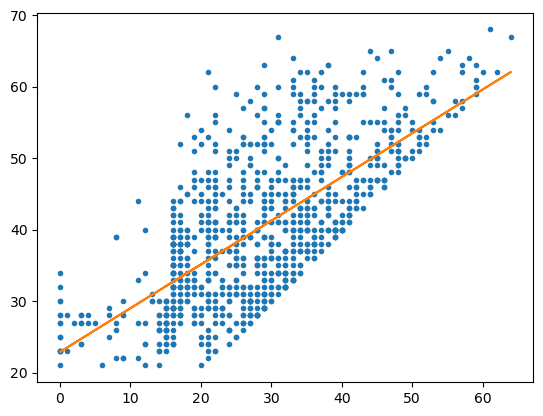

In [312]:
plt.plot(X, y, '.')
plt.plot(X, reg.predict(X))

<AxesSubplot:xlabel='Год смены документа', ylabel='Кол-во полных лет'>

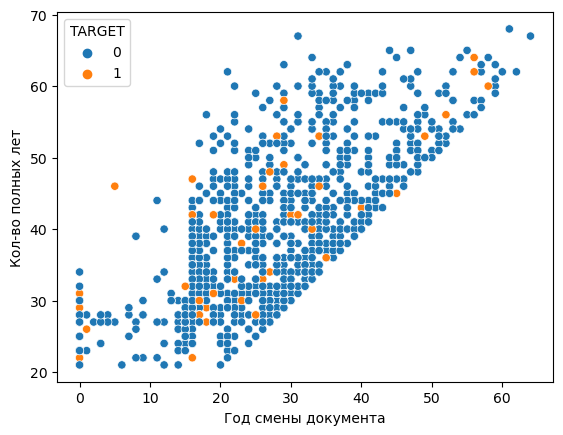

In [313]:
sns.scatterplot(x=application_train_test[feature_1], y=application_train_test[feature_2], hue=application_train_test['TARGET'])

In [314]:
train_X = application_train_test[application_train_test['TARGET'].isin([0, 1])][[feature_1, feature_2]]
train_y = application_train_test[application_train_test['TARGET'].isin([0, 1])]['TARGET']

In [315]:
X = np.linspace(-8, 8, 100)
# plt.plot(X, 1/(1+np.exp(-X)))

In [316]:
X = np.linspace(-4, 4)
# plt.plot(X, np.log2(1+np.exp(-X)))
# plt.plot(X, (-np.sign(X)+1)/2)

In [317]:
from sklearn.linear_model import LogisticRegression

In [318]:
logreg = LogisticRegression()
logreg.fit(train_X, train_y)

LogisticRegression()

<AxesSubplot:xlabel='Год смены документа', ylabel='Кол-во полных лет'>

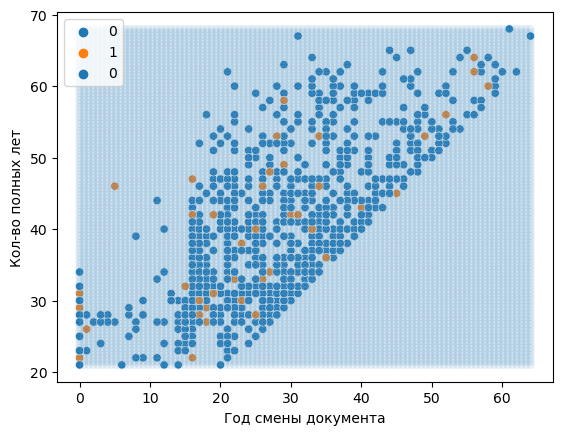

In [319]:
_x = np.linspace(min_feature_1, max_feature_1, 100)
_y = np.linspace(min_feature_2, max_feature_2, 100)
xv, yv = np.meshgrid(_x, _y)
grid = np.vstack([xv.flatten(), yv.flatten()]).T
_pred = logreg.predict(grid)
sns.scatterplot(x=train_X[feature_1], y=train_X[feature_2], hue=train_y)
sns.scatterplot(x=grid[:,0], y=grid[:,1], hue=_pred, alpha=0.1)

In [320]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

In [321]:
tree = DecisionTreeClassifier()
tree.fit(train_X, train_y)

DecisionTreeClassifier()

<AxesSubplot:xlabel='Год смены документа', ylabel='Кол-во полных лет'>

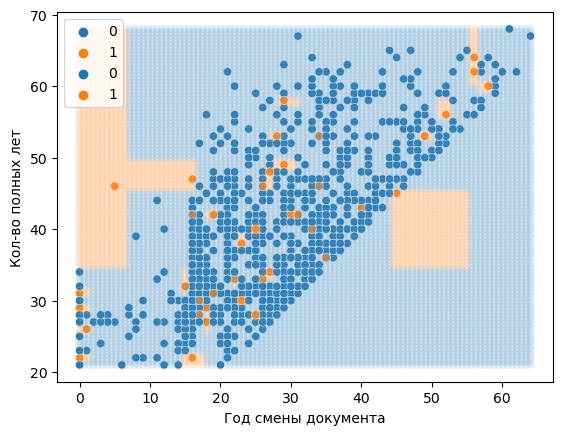

In [322]:
_x = np.linspace(min_feature_1, max_feature_1, 100)
_y = np.linspace(min_feature_2, max_feature_2, 100)
xv, yv = np.meshgrid(_x, _y)
grid = np.vstack([xv.flatten(), yv.flatten()]).T
_pred = tree.predict(grid)

sns.scatterplot(x=train_X[feature_1], y=train_X[feature_2], hue=train_y)
sns.scatterplot(x=grid[:,0], y=grid[:,1], hue=_pred, alpha=0.1)


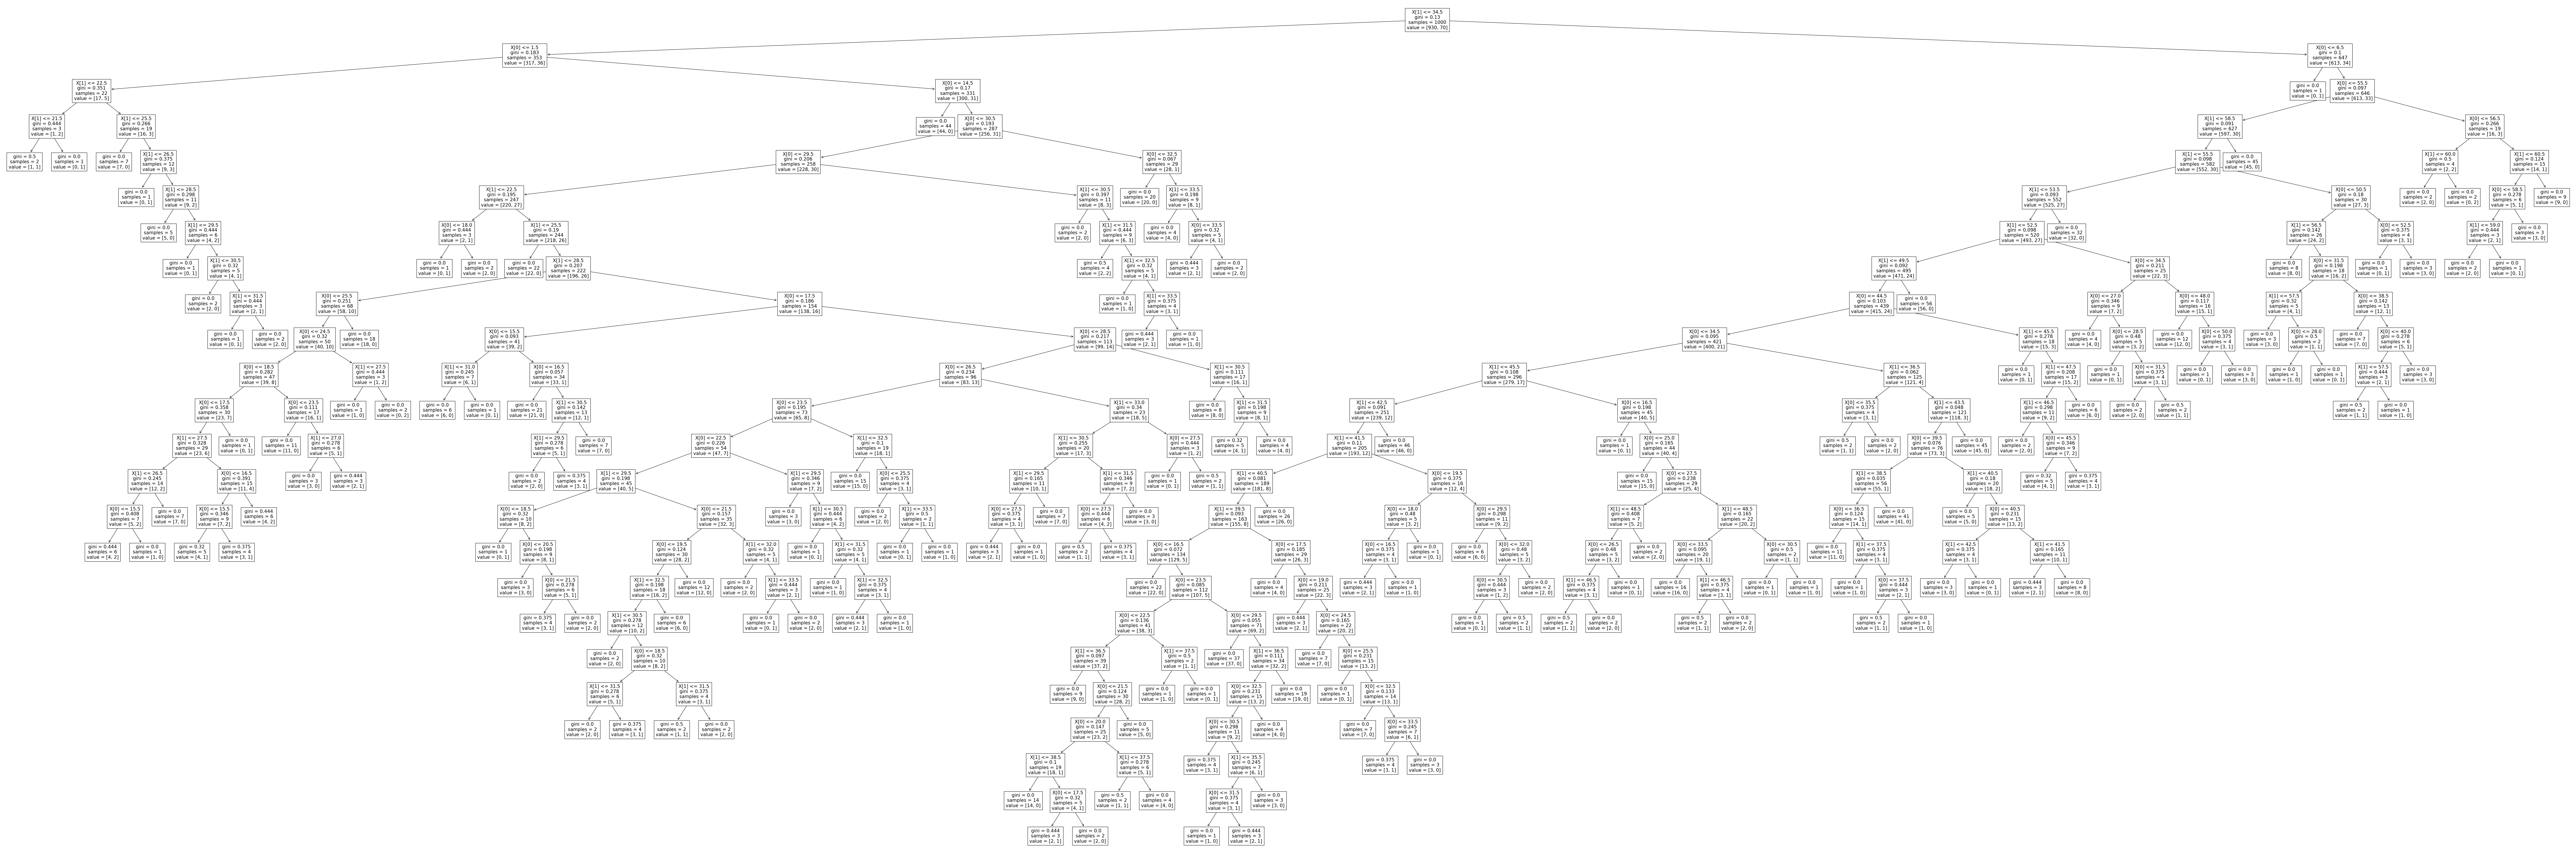

In [323]:
plt.figure(figsize=(150, 50))
_ = plot_tree(tree)

In [324]:
# application_train_test.to_csv('application_train_test.csv', index = False)